# Retrieval Augmented Generation

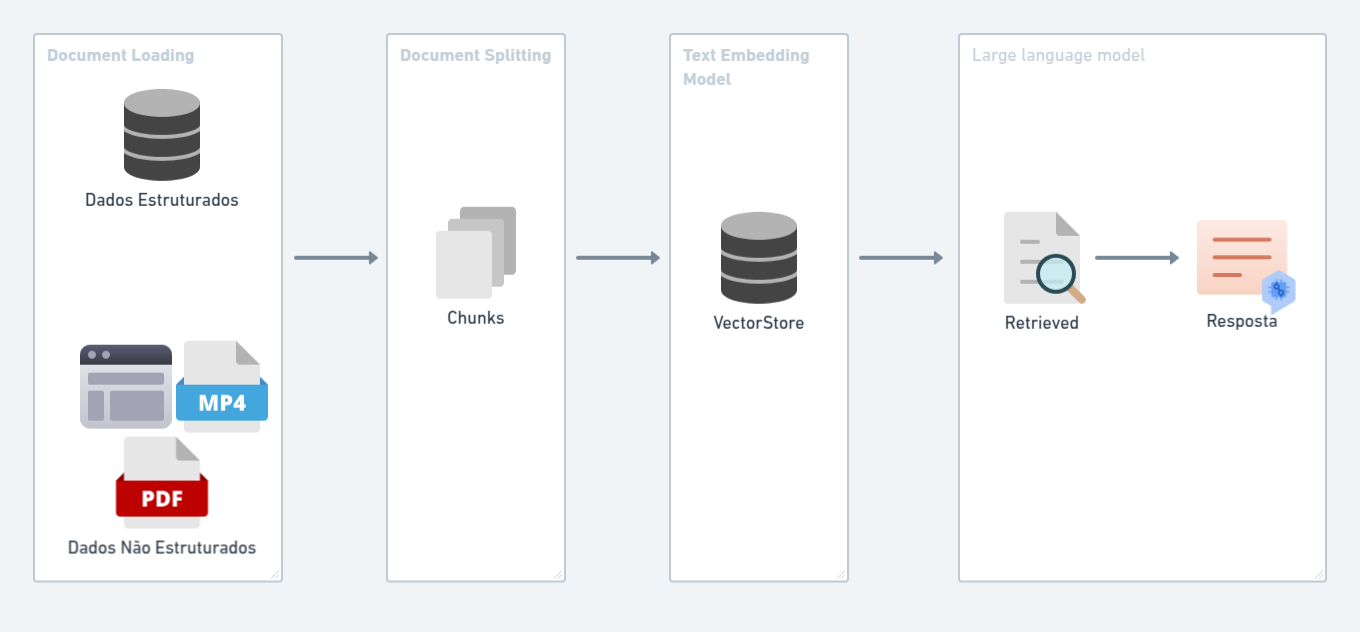

# 1. DocumentLoaders

## Carregando PDFs

In [5]:
from langchain_community.document_loaders.pdf import PyPDFLoader

caminho = './arquivos/ppc.pdf' 
loader = PyPDFLoader(caminho)
documentos = loader.load()

In [ ]:
len(documentos)

In [ ]:
print(documentos[0].page_content)

In [ ]:
documentos[0].metadata

### Fazendo perguntas para o arquivo

In [24]:
from langchain.chains.question_answering import load_qa_chain
from langchain_openai.chat_models import ChatOpenAI

chat = ChatOpenAI(model='gpt-3.5-turbo-0125')

chain = load_qa_chain(llm=chat, chain_type='stuff', verbose=False)

In [ ]:
pergunta = 'Quais assuntos são tratados no documento?'

chain.run(input_documents=documentos[40:50], question=pergunta)

## Carregando csv

In [11]:
from langchain_community.document_loaders.csv_loader import CSVLoader

caminho = 'arquivos/Top 1000 IMDB movies.csv'
loader = CSVLoader(caminho)
documentos = loader.load()

In [12]:
import os
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
# Set cache to save results to memory
from langchain_google_genai import ChatGoogleGenerativeAI
# Carregar as variáveis do arquivo .env
load_dotenv()

# Obter as chaves das APIs
gemini_api_key = os.getenv("GOOGLE_API_KEY")


# Correctly initialize the ChatGoogleGenerativeAI model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=gemini_api_key, top_p=0.30)

In [ ]:
from langchain.chains.question_answering import load_qa_chain
from langchain_openai.chat_models import ChatOpenAI


chain = load_qa_chain(llm=llm, chain_type='stuff', verbose=True)

pergunta = 'Qual é o filme com maior metascore?'
chain.run(input_documents=documentos[:10], question=pergunta)

## Carregando da Internet

O erro HTTP Error 403: Forbidden no yt-dlp geralmente significa que o site bloqueou a requisição, seja por falta de autenticação, restrições regionais ou mudanças no método de acesso.

solução (Atualizar o yt-dlp): pip install -U yt-dlp


In [ ]:
import os
import subprocess

from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser

# Cria o diretório de destino, se não existir
save_dir = 'docs/youtube'
os.makedirs(save_dir, exist_ok=True)

# URL do vídeo do YouTube
url = 'https://www.youtube.com/watch?v=_IxHzJWXP_M'

# Comando para baixar e extrair o áudio em formato mp3 usando yt-dlp
# O parâmetro -o define o caminho/filename sem extensão; yt-dlp adicionará a extensão apropriada.
command = [
    "yt-dlp", "-x", "--audio-format", "mp3",
    "-o", os.path.join(save_dir, "audio.%(ext)s"),
    url
]

# Executa o comando e verifica se ocorreu algum erro
subprocess.run(command, check=True)

# Caminho para o arquivo de áudio baixado 
audio_file_path = os.path.join(save_dir, "audio.mp3")

# Instancia o loader para o arquivo local
loader = GenericLoader(
    FileSystemBlobLoader(audio_file_path),
    OpenAIWhisperParser()
)

# Carrega o documento (a transcrição)
docs = loader.load()

# Exibe o conteúdo transcrito
for doc in docs:
    print(doc.page_content)


# 2. Text Splitting


O objetivo principal ao dividir documentos em partes menores é garantir que um modelo de linguagem (LLM) receba apenas os trechos mais relevantes para uma determinada consulta. No entanto, surge a seguinte questão:

> **Como podemos segmentar o texto sem comprometer a integridade da informação?**

Vamos analisar um exemplo. Suponha que temos o seguinte trecho:




Agora, imagine que essa informação seja dividida incorretamente da seguinte maneira:

- `"O novo modelo da Renault é"`
- `"o Duster, possui 110"`
- `"cavalos de potência e"`
- `"um preço estimado de"`
- `"180 mil reais."`

Nesse caso, cada fragmento isolado perde seu significado completo, tornando-se menos útil para processamento ou análise. Isso mostra a importância de uma segmentação bem estruturada, evitando cortes que prejudiquem o contexto da informação.

---


Utilizar os parâmetros de overlap já auxiliam para minimizar este tipo de problema:

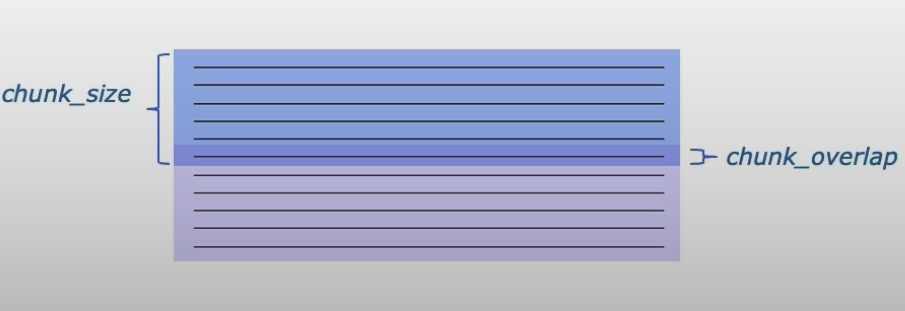

Dessa forma, mantemos parte dos dados do trecho anterior no trecho seguinte, evitando saltos bruscos de conteúdo entre as partes.